### After confirming our dataset is a candidate for the Prophet Model, let's build the model!

In [0]:
import pandas as pd
import warnings
from fbprophet import Prophet
import plotly.express as px
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

Load the data

In [0]:
#@title
df = pd.read_csv('https://raw.githubusercontent.com/soumilshah1995/Data-Analysis-Over-10-years-of-hourly-energy-consumption-data-from-PJM-in-Megawatts/master/AEP_hourly.csv', sep=",")

Prophet requires the columns of the dataset to be: ***'ds'*** and ***'y'***



1.   ds = Datetime / Date
2.   y = Observations / Variable to Predict





In [3]:
df.columns = ['ds', 'y']
df.head(5)

,ds,y
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


While Prophet can predict hourly data, it is more intuitive to think about forecasting daily for Revenue Forecasting.

*   Therefore, let's resample our data to daily instead of hourly





In [0]:
#@title
#Set Datetime column to the index and convert index to Datetime data type
df.set_index('ds', inplace=True)
df.index = pd.to_datetime(df.index)
#Convert Hourly to Daily by resampling daily ['D'] and taking the mean
df = df.resample('D').mean() 

Great - we have our daily data back. Let's see what it looks like:


In [5]:
df.head(3)

,y
ds,
2004-10-01,14284.521739
2004-10-02,12999.875000
2004-10-03,12227.083333


Step 1: Create Holiday Calendar



*  Prophet has a built in 'US' holiday calendar, but we want to add holidays that are specific to our organization. 
* This list is not exhastive for 2004 - 2020 but rather a sample to demonstrate the process for adding holidays.


In [0]:
holidays = pd.DataFrame({
  'holiday': 'date',
  'ds': pd.to_datetime(['2017-12-26', '2017-12-27', '2017-12-28',
                        '2017-12-29', '2017-12-30', '2017-07-03',
                        '2017-07-04', '2017-07-06', '2017-07-07',
                        '2018-12-26', '2018-12-27', '2018-12-28',
                        '2018-12-29', '2018-12-30', '2018-07-02',
                        '2018-07-03', '2018-07-05', '2018-07-07',
                        '2019-12-26', '2019-12-27', '2019-12-28',
                        '2019-12-29', '2019-12-30', '2019-07-01',
                        '2019-07-02', '2019-07-03', '2019-07-05',]),
  'lower_window': 0,
  'upper_window': 1,
})

Split into Train and Test Set

In [0]:
df['ds'] = df.index
test = df[df.index  >= '2015-01-01']
train = df[df.index  <= '2015-01-01']

We're only going to add a Holiday Calendar and leave all other parameters as default. This process is specific to the dataset we are forecasting.

In [8]:
#Add our holiday calendar to model
m = Prophet(holidays=holidays)
#Add US holidays to the model
m.add_country_holidays(country_name='US')

m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Pass in the Testing Dataset to forecast

In [9]:
forecast = m.predict(test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,"Martin Luther King, Jr. Day","Martin Luther King, Jr. Day_lower","Martin Luther King, Jr. Day_upper",Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,date,date_lower,date_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,14998.831104,13544.079626,16399.603018,14998.831104,14998.831104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1330.010244,-1330.010244,-1330.010244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.762796,37.762796,37.762796,0.0,0.0,0.0,-1330.010244,-1330.010244,-1330.010244,574.753219,574.753219,574.753219,793.019822,793.019822,793.019822,0.0,0.0,0.0,15036.593901
1,2015-01-02,14998.306303,14583.336209,17485.752642,14998.306303,14998.306303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1082.739494,1082.739494,1082.739494,0.0,0.0,0.0,0.000000,0.000000,0.000000,259.004329,259.004329,259.004329,823.735165,823.735165,823.735165,0.0,0.0,0.0,16081.045797
2,2015-01-03,14997.781501,13524.159961,16296.478065,14997.781501,14997.781501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-77.564566,-77.564566,-77.564566,0.0,0.0,0.0,0.000000,0.000000,0.000000,-944.507160,-944.507160,-944.507160,866.942594,866.942594,866.942594,0.0,0.0,0.0,14920.216935
3,2015-01-04,14997.256699,13104.683190,16060.840736,14997.256699,14997.256699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-442.458027,-442.458027,-442.458027,0.0,0.0,0.0,0.000000,0.000000,0.000000,-1364.587441,-1364.587441,-1364.587441,922.129414,922.129414,922.129414,0.0,0.0,0.0,14554.798672
4,2015-01-05,14996.731898,14887.812799,17746.343263,14996.731898,14996.731898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1359.376721,1359.376721,1359.376721,0.0,0.0,0.0,0.000000,0.000000,0.000000,370.864430,370.864430,370.864430,988.512291,988.512291,988.512291,0.0,0.0,0.0,16356.108619


We need to join the actual test data to the forecasted data

In [0]:
forecast_new = forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

#Both the index and column are named 'ds' which won't work for the join 
test.index.names = ['Date']
complete_test = pd.merge(test, forecast_new, on='ds', how='left')


In [11]:
complete_test.head()

,y,ds,yhat_lower,yhat_upper,yhat
0,15985.250000,2015-01-01,13544.079626,16399.603018,15036.593901
1,15515.791667,2015-01-02,14583.336209,17485.752642,16081.045797
2,14698.250000,2015-01-03,13524.159961,16296.478065,14920.216935
3,13634.875000,2015-01-04,13104.683190,16060.840736,14554.798672
4,17810.083333,2015-01-05,14887.812799,17746.343263,16356.108619


Visualizing the forecasts

In [12]:
#@title
fig = go.Figure()

# fig.add_trace(go.Scatter(x=train['ds'], y=train['y'],
#                     mode='lines', line_color='#ff19e8',
#                     name='Actual Energy Usage'))

fig.add_trace(go.Scatter(x=complete_test['ds'], y=complete_test['y'],
                    mode='lines', line_color='#ff19e8',
                    name='Actual Energy Usage'))
fig.add_trace(go.Scatter(x=complete_test['ds'], y=complete_test['yhat'], line_color ='#19ff9c',
                    mode='lines', name='Predicted Energy Usage'))

# fig.add_trace(go.Scatter(x=complete_test['ds'], y=complete_test['yhat_lower'], fill='toself',
#                     fillcolor='rgba(231,107,243,0.5)',
#                     line_color='rgba(255,255,255,0)',
#                    name='Lower Prediction Interval'))
# fig.add_trace(go.Scatter(x=complete_test['ds'], y=complete_test['yhat_upper'],  fill='toself',
#                     fillcolor='rgba(204, 255, 20,0.5)',
#                     line_color='rgba(255,255,255,0)',
#                     name='Upper Prediction Interval'))

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),

    template = 'plotly_dark', 
    title="Prophet Forecasting Validation - Visual Checkpoint",
    xaxis_title="Date",
    yaxis_title="Energy Usage",
    font=dict(
        family="Computer Modern",
        size=14,
        color="#7f7f7f"
    )

)

fig.show()

Calculating Absolute Percentage Error and the MAPE

Absolute Percentage Error = [Actual - Forecasted] / Actual

MAPE = Mean of Absolute Percentage Error

In [13]:
complete_test['PE'] = (abs(complete_test['y'] - complete_test['yhat']) / complete_test['y'])
print("MAPE: " + "{0:.3%}".format(complete_test['PE'].mean()))

MAPE: 6.796%


We can also decompose what the model learns from the data

For ***Revenue Forecasting*** this is particularly useful for highlighting yearly and weekly seasonality in sales.

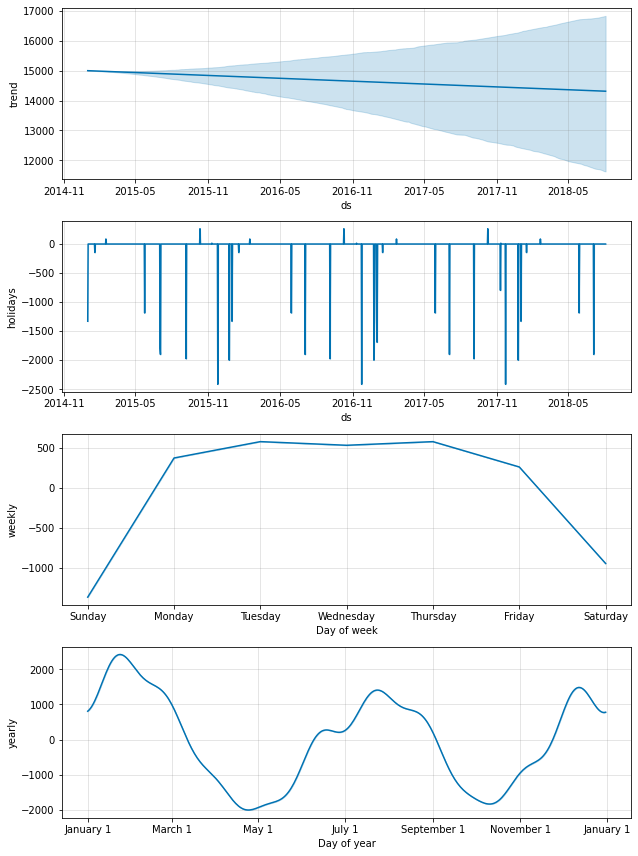

In [14]:
fig2 = m.plot_components(forecast)

The Mean Absolute Percentage Error is 6.80% - validating the models success on training and testing data.

Now let's forecast into the future!

In [15]:
#Add our holiday calendar to model
m = Prophet(holidays=holidays)

#Add US holidays to the model
m.add_country_holidays(country_name='US')

#Retrain model on complete dataset
m.fit(df)

#Generate dataframe into the future
future = m.make_future_dataframe(periods=365)
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
5415,2019-07-30
5416,2019-07-31
5417,2019-08-01
5418,2019-08-02
5419,2019-08-03


In [0]:
#Make the forecasts
forecast = m.predict(future)

In [18]:
#@title
fig = go.Figure()

# fig.add_trace(go.Scatter(x=train['ds'], y=train['y'],
#                     mode='lines', line_color='#ff19e8',
#                     name='Actual Energy Usage'))

fig.add_trace(go.Scatter(x=df['ds'], y=df['y'],
                    mode='lines', line_color='#ff19e8',
                    name='Actual Energy Usage'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], line_color ='#19ff9c',
                    mode='lines', name='Predicted Energy Usage'))

# fig.add_trace(go.Scatter(x=complete_test['ds'], y=complete_test['yhat_lower'], fill='toself',
#                     fillcolor='rgba(231,107,243,0.5)',
#                     line_color='rgba(255,255,255,0)',
#                    name='Lower Prediction Interval'))
# fig.add_trace(go.Scatter(x=complete_test['ds'], y=complete_test['yhat_upper'],  fill='toself',
#                     fillcolor='rgba(204, 255, 20,0.5)',
#                     line_color='rgba(255,255,255,0)',
#                     name='Upper Prediction Interval'))

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),

    template = 'plotly_dark', 
    title="Prophet Forecasting - Forecasting Output",
    xaxis_title="Date",
    yaxis_title="Energy Usage",
    font=dict(
        family="Computer Modern",
        size=14,
        color="#7f7f7f"
    )

)

fig.show()